<a href="https://colab.research.google.com/github/Meghanth/brain-tumor-classification-and-segmentation/blob/main/Classification_brain_tumor_meghanth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install -q keras

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
data.head(10)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
5,TCGA_CS_5395,2.0,4.0,2,2.0,NaN,3.0,2,3.0,1.0,1.0,3.0,5.0,2.0,43.0,2.0,NaN,1.0
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0
7,TCGA_CS_5397,NaN,4.0,1,2.0,3.0,3.0,2,1.0,2.0,1.0,1.0,6.0,1.0,54.0,3.0,2.0,1.0
8,TCGA_CS_6186,2.0,4.0,1,2.0,1.0,3.0,2,2.0,2.0,1.0,3.0,2.0,2.0,58.0,3.0,2.0,1.0
9,TCGA_CS_6188,2.0,4.0,3,2.0,3.0,3.0,2,1.0,2.0,1.0,3.0,6.0,2.0,48.0,3.0,2.0,0.0


In [ ]:
import glob
glob.glob('/pycharm/*') 
import os
data_map = []
for sub_dir_path in glob.glob("/content/drive/MyDrive/Colab Notebooks/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

In [ ]:
import pandas as pd
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/lgg-mri...
1,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/lgg-mri...
2,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/lgg-mri...
3,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/lgg-mri...
4,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/lgg-mri...


In [ ]:
import random
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values)
masks = sorted(df_masks["path"].values)

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/drive/MyDrive/Colab Notebooks/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_18.tif 
Path to the Mask: /content/drive/MyDrive/Colab Notebooks/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_19_mask.tif


In [ ]:
# Final dataframe
import pandas as pd
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,0
1,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,1
2,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,1
3,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,1
4,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,1
...,...,...,...,...
3924,TCGA_CS_6186_20000601,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,0
3925,TCGA_CS_6186_20000601,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,0
3926,TCGA_CS_6186_20000601,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,0
3927,TCGA_CS_6186_20000601,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,0


In [ ]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [ ]:
import plotly.graph_objects as go  # using plotly to create interactive plots

fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index, 
                        y=brain_df['mask'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Mask Count Plot",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

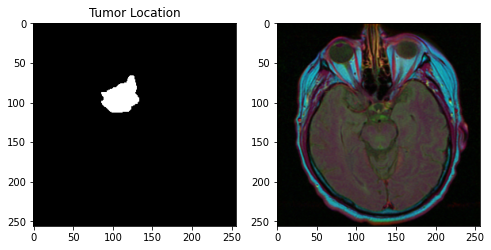

In [ ]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

In [ ]:
cv2.imread(brain_df.mask_path[i]).max(), cv2.imread(brain_df.mask_path[i]).min()

(255, 0)

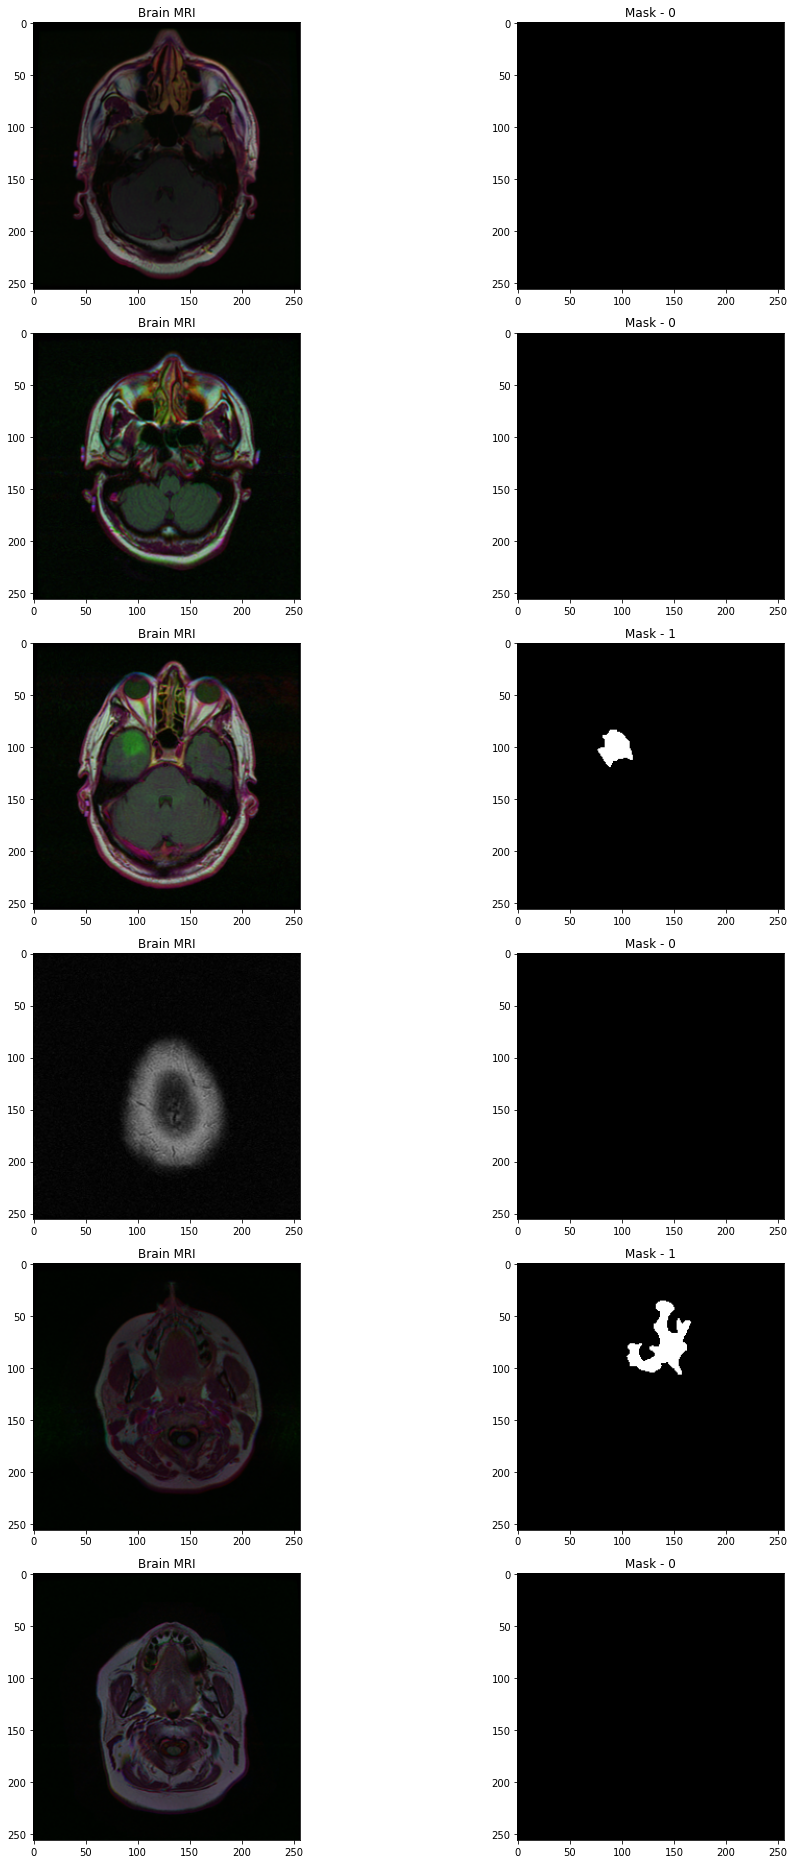

In [ ]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 

fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

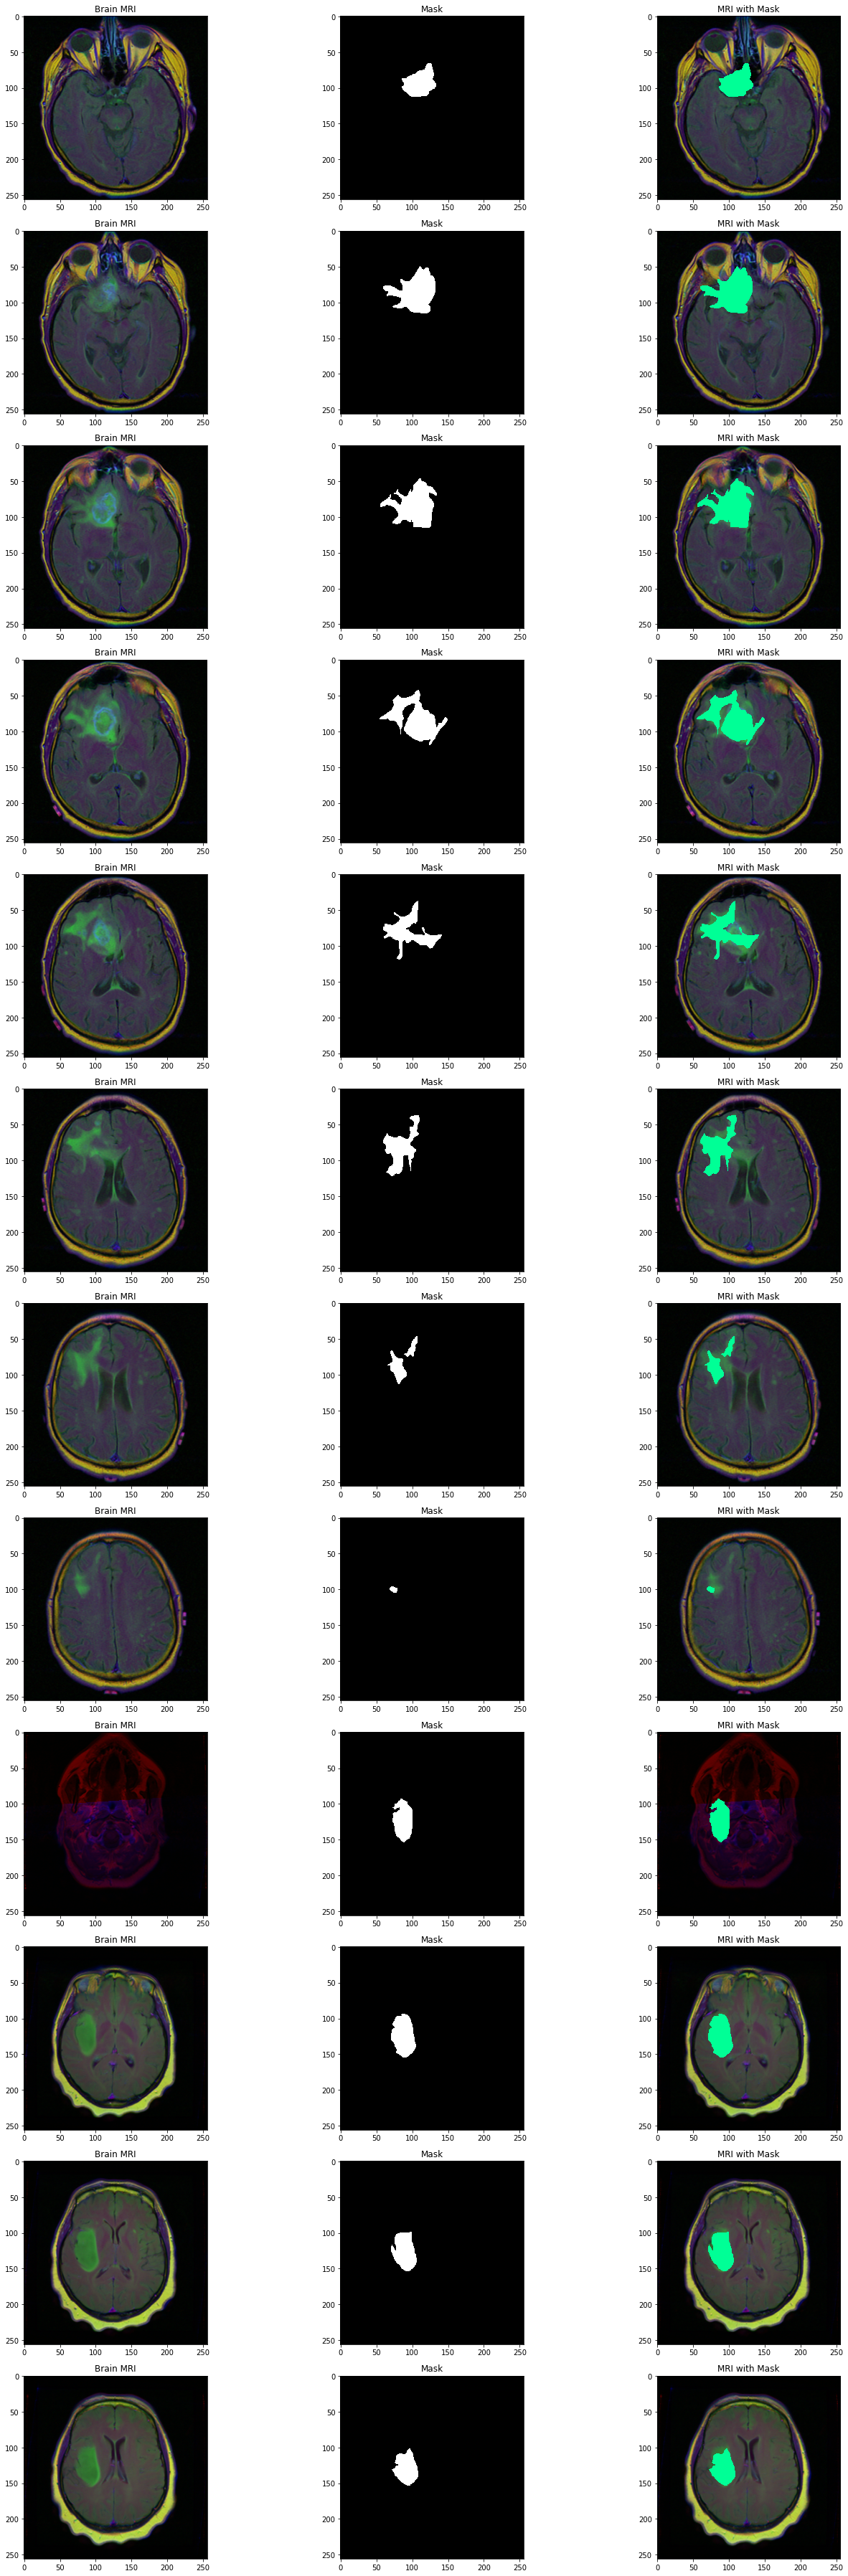

In [ ]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

In [ ]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15)

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                              )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
clf_model.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
# before this i tried with trainable layer but the accuracy was less as compared
for layer in clf_model.layers:
    layers.trainable = False

In [ ]:
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [ ]:
h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 30, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

Epoch 1/30
187/187 [==============================] - 863s 4s/step - loss: 1.0511 - accuracy: 0.6438 - val_loss: 8.5401 - val_accuracy: 0.6500

Epoch 00001: val_loss improved from inf to 8.54010, saving model to clf-resnet-weights.hdf5
Epoch 2/30
187/187 [==============================] - 42s 225ms/step - loss: 0.5590 - accuracy: 0.7575 - val_loss: 0.8674 - val_accuracy: 0.3469

Epoch 00002: val_loss improved from 8.54010 to 0.86736, saving model to clf-resnet-weights.hdf5
Epoch 3/30
187/187 [==============================] - 43s 231ms/step - loss: 0.4643 - accuracy: 0.7892 - val_loss: 0.6453 - val_accuracy: 0.6531

Epoch 00003: val_loss improved from 0.86736 to 0.64535, saving model to clf-resnet-weights.hdf5
Epoch 4/30
187/187 [==============================] - 43s 228ms/step - loss: 0.4789 - accuracy: 0.7905 - val_loss: 0.6106 - val_accuracy: 0.6656

Epoch 00004: val_loss improved from 0.64535 to 0.61058, saving model to clf-resnet-weights.hdf5
Epoch 5/30
187/187 [==================

In [ ]:
# saving model achitecture in json file
model_json = model.to_json()
with open("clf-resnet-model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

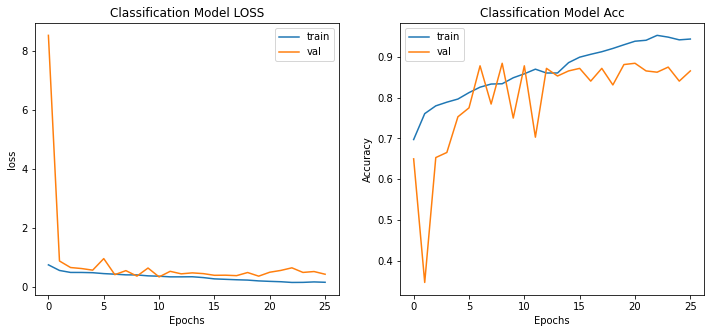

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 141s 4s/step - loss: 0.5825 - accuracy: 0.8644
Test accuracy : 86.44067645072937 %


0.864406779661017
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       363
           1       0.88      0.75      0.81       227

    accuracy                           0.86       590
   macro avg       0.87      0.84      0.85       590
weighted avg       0.87      0.86      0.86       590



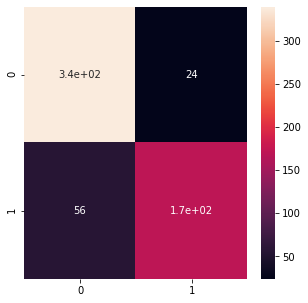

In [ ]:
prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

In [ ]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103
